# Assignment 10

### 1.复习上课内容

In [1]:
# 1.SVM
import numpy as np
from sklearn import datasets
from sklearn.svm import SVC

iris = datasets.load_iris()
X = iris['data'][:,(2,3)] # patal length , petal width
Y = iris['target']==0
cls = SVC()
cls.fit(X,Y)
cls.predict([[-0.8,-1]])

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


array([False])

In [2]:
# 2.Random Forest
from sklearn.ensemble import RandomForestClassifier
rnd_clf = RandomForestClassifier(n_estimators=500)
rnd_clf.fit(iris['data'],iris['target'])
# iris
rnd_clf.predict([[5.1, 3.5, 1.4, 0.2]])

array([0])

In [3]:
# 3.XGboost
from xgboost import XGBClassifier
xg = XGBClassifier()
xg.fit(iris['data'],iris['target'])
xg.predict( [[5.5, 3.5, 1.3, 0.2]])

array([0])

### 2. 回答一下理论题目

#### 1. What is independent assumption in Naive bayes ?什么是朴素贝叶斯算法中的独立性假设？

贝叶斯算法中假设样本X中的n个维度之间相互独立。贝叶斯公式中的𝑃(𝑋1=𝑥1,𝑋2=𝑥2,...𝑋𝑛=𝑥𝑛|𝑌=𝐶𝑘)是一个有n个维度的条件分布，很难求出；通过假设这n个维度间相互独立，可以将式子简化为𝑃(𝑋1=𝑥1|𝑌=𝐶𝑘)𝑃(𝑋2=𝑥2|𝑌=𝐶𝑘)...𝑃(𝑋𝑛=𝑥𝑛|𝑌=𝐶𝑘)，一定程度上是牺牲了准确度来降低计算的难度。

#### 2. What is MAP(maximum a posterior) and ML(maximum likelihood) ?最大后验和最大似然是什么？

假如我们知道一组观测数据是从某一种分布中随机取出来的，但不知道这个分布具体的参数，MLE的目标就是找出一组参数，使得模型产生出观测数据的概率最大；在先验分布的基础上增加样本进行修正后会得到后验分布MAP。

#### 3. What is support vector in SVM?SVM中的支持向量是什么？

距离超平面最近的且满足一定条件的几个训练样本点决定了超平面的位置。对硬间隔，支持向量是位于间隔边界上的样本点(𝑦(𝑤𝑇𝑥+𝑏) = 1);对软间隔，支持向量是位于间隔边界上及间隔边界之内的样本点。

#### 4. What is the intuition behind SVM ?引入SVM的动机是什么？

假定在一个数据集中所有的数据都已被标记为两类，能找到一个超平面将其完美分类。SVM中假设拥有最大间隔的超平面效果最好，因此要找到一个最优的决策边界。

#### 5. Shortly describ what 'random' means in random forest ?简要描述随机森林中的“随机”是指什么？

1）如果训练集大小为N，对于每棵树而言，随机且有放回地从训练集中的抽取N个训练样本（这种采样方式称为bootstrap sample方法），作为该树的训练集；

2）如果每个样本的特征维度为M，指定一个常数m<<M，随机地从M个特征中选取m个特征子集，每次树进行分裂时，从这m个特征中选择最优的。

由于它们的引入，使得随机森林不容易陷入过拟合，并且具有很好得抗噪能力（比如：对缺省值不敏感）。

#### 6. What criterion does XGBoost use to find the best split point in a tree ?XGBoost中用什么标准来寻找最佳分裂点？

决策树的学习最耗时的一个步骤就是对特征的值进行排序（因为要确定最佳分割点）。XGBoost在训练之前，预先对数据进行了排序，然后保存为block结构，后面的迭代中重复地使用这个结构，大大减小计算量。在进行节点的分裂时，需要计算每个特征的增益，最终选增益最大的那个特征去做分裂，那么各个特征的增益计算就可以开多线程进行。

XGBoost提供了一种直方图近似算法，对特征排序后仅选择常数个候选分裂位置作为候选分裂点，提升了结点分裂时的计算效率。

### 3. Practial part

##### Problem description: In this part you are going to build a classifier to detect if a piece of news is published by the Xinhua news agency (新华社）.

#### Hints:

###### 1. Firstly, you have to come up with a way to represent the news. (Vectorize the sentence, you can find different ways to do so online)  

尝试用 TF-IDF 和 LDA 表示文本

###### 2. Secondly,  pick a machine learning algorithm that you think is suitable for this task

使用Random Forest

#### 预处理

In [4]:
import pandas as pd
import numpy as np
import re
import time
import pickle

pd.set_option('display.max_colwidth', 200)

In [7]:
# 1.导入和检查数据
data = pd.read_csv('新华社数据.csv', encoding='gb18030')
print(data.shape)
data.describe(include=[np.object])

(89611, 7)


,author,source,content,feature,title,url
count,79396,89609,87054,89611,89577,87144
unique,5601,974,74917,89184,85253,87124
top,薛之谦的小意外,新华社,\n\n,"{""commentNum"":""0"",""forwardNum"":""23"",""playNum"":""0"",""mid"":""4115003466933405"",""type"":""图文"",""favoriteNum"":""0"",""likeNum"":""13""}",国际重要稿件预告,http://www.paigu.com/a/424619/49449882.html
freq,871,78661,177,3,219,2


In [8]:
# 2.分词并增加文本长度和标签
import jieba

def cut(article): 
    segments = []
    for sentence in article.split('\n'):
        sentence = ''.join(re.findall(r'\w', sentence))
        for x in jieba.cut(sentence):
            segments.append(x)
    
    return ' '.join(segments)

data['content_after_jieba'] = data['content'].astype(str).apply(cut)
data['article_length'] = data['content'].astype(str).apply(lambda x : len(x))
data['label'] = np.where(data['source'].str.find('新华社'), 0, 1)

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/ng/1yxn2hp94vb65hy2rqh73__c0000gp/T/jieba.cache
Loading model cost 0.958 seconds.
Prefix dict has been built successfully.


In [11]:
data.head()

,id,author,source,content,feature,title,url,content_after_jieba,article_length,label
0,89617,NaN,快科技@http://www.kkj.cn/,此外，自本周（6月12日）起，除小米手机6等15款机型外，其余机型已暂停更新发布（含开发版/体验版内测，稳定版暂不受影响），以确保工程师可以集中全部精力进行系统优化工作。有人猜测这也是将精力主要用到MIUI 9的研发之中。\r\nMIUI 8去年5月发布，距今已有一年有余，也是时候更新换代了。\r\n当然，关于MIUI 9的确切信息，我们还是等待官方消息。\r\n,"{""type"":""科技"",""site"":""cnbeta"",""commentNum"":""37"",""joinNum"":""20007"",""clickNum"":""19920"",""shareNum"":""0"",""url"":""http://www.cnbeta.com/articles/tech/623597.htm"",""site_sign"":""cnbeta"",""label"":"""",""summary"":...",小米MIUI 9首批机型曝光：共计15款,http://www.cnbeta.com/articles/tech/623597.htm,此外 自 本周 6 月 12 日起 除 小米 手机 6 等 15 款 机型 外 其余 机型 已 暂停 更新 发布 含 开发 版 体验版 内测 稳定版 暂不受 影响 以 确保 工程师 可以 集中 全部 精力 进行 系统优化 工作 有人 猜测 这 也 是 将 精力 主要 用到 MIUI9 的 研发 之中 MIUI8 去年 5 月 发布 距今已有 一年 有余 也 是 时候 更新换代 了 当然 关...,177,0
1,89616,NaN,快科技@http://www.kkj.cn/,骁龙835作为唯一通过Windows 10桌面平台认证的ARM处理器，高通强调，不会因为只考虑性能而去屏蔽掉小核心。相反，他们正联手微软，找到一种适合桌面平台的、兼顾性能和功耗的完美方案。\r\n报道称，微软已经拿到了一些新的源码，以便Windows 10更好地理解big.little架构。\r\n资料显示，骁龙835作为一款集成了CPU、GPU、基带、蓝牙/Wi-Fi的SoC，比传统的W...,"{""type"":""科技"",""site"":""cnbeta"",""commentNum"":""15"",""joinNum"":""5522"",""clickNum"":""5493"",""shareNum"":""0"",""url"":""http://www.cnbeta.com/articles/tech/623599.htm"",""site_sign"":""cnbeta"",""label"":"""",""summary"":""尽...",骁龙835在Windows 10上的性能表现有望改善,http://www.cnbeta.com/articles/tech/623599.htm,骁龙 835 作为 唯一 通过 Windows10 桌面 平台 认证 的 ARM 处理器 高通 强调 不会 因为 只 考虑 性能 而 去 屏蔽掉 小 核心 相反 他们 正 联手 微软 找到 一种 适合 桌面 平台 的 兼顾 性能 和 功耗 的 完美 方案 报道 称 微软 已经 拿到 了 一些 新 的 源码 以便 Windows10 更好 地 理解 biglittle 架构 资料 显示 骁龙...,329,0
2,89615,NaN,快科技@http://www.kkj.cn/,此前的一加3T搭载的是3400mAh电池，DashCharge快充规格为5V/4A。\r\n至于电池缩水，可能与刘作虎所说，一加手机5要做市面最轻薄大屏旗舰的设定有关。\r\n按照目前掌握的资料，一加手机5拥有5.5寸1080P三星AMOLED显示屏、6G/8GB RAM，64GB/128GB ROM，双1600万摄像头，备货量“惊喜”。\r\n根据京东泄露的信息，一加5起售价是xx99元...,"{""type"":""科技"",""site"":""cnbeta"",""commentNum"":""18"",""joinNum"":""9445"",""clickNum"":""9425"",""shareNum"":""0"",""url"":""http://www.cnbeta.com/articles/tech/623601.htm"",""site_sign"":""cnbeta"",""label"":"""",""summary"":""本...",一加手机5细节曝光：3300mAh、充半小时用1天,http://www.cnbeta.com/articles/tech/623601.htm,此前 的 一加 3T 搭载 的 是 3400mAh 电池 DashCharge 快充 规格 为 5V4A 至于 电池 缩水 可能 与 刘作 虎 所说 一加 手机 5 要 做 市面 最 轻薄 大屏 旗舰 的 设定 有关 按照 目前 掌握 的 资料 一加 手机 5 拥有 55 寸 1080P 三星 AMOLED 显示屏 6G8GBRAM64GB128GBROM 双 1600 万 摄像头 备货 ...,216,0
3,89614,NaN,新华社,这是6月18日在葡萄牙中部大佩德罗冈地区拍摄的被森林大火烧毁的汽车。新华社记者张立云摄\r\n,"{""type"":""国际新闻"",""site"":""环球"",""commentNum"":""0"",""joinNum"":""0"",""clickNum"":""0"",""shareNum"":""0"",""url"":""http://world.huanqiu.com/hot/2017-06/10866126.html"",""site_sign"":""huanqiu"",""label"":"""",""summary"":""这是6月1...",葡森林火灾造成至少62人死亡 政府宣布进入紧急状态（组图）,http://world.huanqiu.com/hot/2017-06/10866126.html,这是 6 月 18 日 在 葡萄牙 中部 大 佩德罗 冈 地区 拍摄 的 被 森林 大火 烧毁 的 汽车 新华社 记者 张立 云摄,45,1
4,89613,胡淑丽_MN7479,深圳大件事,（原标题：44岁女子跑深圳约会网友被拒，暴雨中裸身奔走……）\r\n@深圳交警微博称：昨日清晨交警发现有一女子赤裸上身，行走在南坪快速上，期间还起了轻生年头，一辅警发现后赶紧为其披上黄衣，并一路劝说她。\r\n那么事发时\r\n到底都发生了些什么呢？\r\n南都记者带您一起还原现场\r\n南都记者在龙岗大队坂田中队见到了辅警刘青（发现女生的辅警），一位外表高大帅气，说话略带些腼腆的90后青...,"{""type"":""新闻"",""site"":""网易热门"",""commentNum"":""978"",""joinNum"":""16252"",""clickNum"":""0"",""shareNum"":""0"",""url"":""http://news.163.com/17/0618/00/CN617P3Q0001875P.html"",""site_sign"":""wangyi"",""label"":""[]"",""summar...",44岁女子约网友被拒暴雨中裸奔 交警为其披衣相随,http://news.163.com/17/0618/00/CN617P3Q0001875P.html,原 标题 44 岁 女子 跑 深圳 约会 网友 被 拒 暴雨 中 裸身 奔走 深圳 交警 微博称 昨日 清晨 交警 发现 有 一 女子 赤裸 上身 行走 在 南坪 快速 上 期间 还 起 了 轻生 年头 一辅警 发现 后 赶紧 为 其 披上 黄衣 并 一路 劝说 她 那么 事发 时 到底 都 发生 了 些 什么 呢 南 都 记者 带 您 一起 还原 现场 南 都 记者 在 龙岗 大队 坂田...,1674,0


In [14]:
# 3.新建一个Dataframe并去除内容中的重复值和空值
# DataFrame.dropna(self, axis=0, how='any', thresh=None, subset=None, inplace=False)
new_corpus = data[['title', 'content_after_jieba', 'article_length', 'label']]
new_corpus.describe(include = 'all')
new_corpus = new_corpus.drop_duplicates(subset = ['content_after_jieba'])
new_corpus = new_corpus.dropna(subset = ['content_after_jieba'])

In [21]:
new_corpus.describe()

,article_length,label
count,74857.000000,74857.000000
mean,492.728616,0.891767
std,703.764718,0.310677
min,3.000000,0.000000
25%,139.000000,1.000000
50%,207.000000,1.000000
75%,570.000000,1.000000
max,22422.000000,1.000000


In [17]:
new_corpus.head()

,title,content_after_jieba,article_length,label
0,小米MIUI 9首批机型曝光：共计15款,此外 自 本周 6 月 12 日起 除 小米 手机 6 等 15 款 机型 外 其余 机型 已 暂停 更新 发布 含 开发 版 体验版 内测 稳定版 暂不受 影响 以 确保 工程师 可以 集中 全部 精力 进行 系统优化 工作 有人 猜测 这 也 是 将 精力 主要 用到 MIUI9 的 研发 之中 MIUI8 去年 5 月 发布 距今已有 一年 有余 也 是 时候 更新换代 了 当然 关...,177,0
1,骁龙835在Windows 10上的性能表现有望改善,骁龙 835 作为 唯一 通过 Windows10 桌面 平台 认证 的 ARM 处理器 高通 强调 不会 因为 只 考虑 性能 而 去 屏蔽掉 小 核心 相反 他们 正 联手 微软 找到 一种 适合 桌面 平台 的 兼顾 性能 和 功耗 的 完美 方案 报道 称 微软 已经 拿到 了 一些 新 的 源码 以便 Windows10 更好 地 理解 biglittle 架构 资料 显示 骁龙...,329,0
2,一加手机5细节曝光：3300mAh、充半小时用1天,此前 的 一加 3T 搭载 的 是 3400mAh 电池 DashCharge 快充 规格 为 5V4A 至于 电池 缩水 可能 与 刘作 虎 所说 一加 手机 5 要 做 市面 最 轻薄 大屏 旗舰 的 设定 有关 按照 目前 掌握 的 资料 一加 手机 5 拥有 55 寸 1080P 三星 AMOLED 显示屏 6G8GBRAM64GB128GBROM 双 1600 万 摄像头 备货 ...,216,0
3,葡森林火灾造成至少62人死亡 政府宣布进入紧急状态（组图）,这是 6 月 18 日 在 葡萄牙 中部 大 佩德罗 冈 地区 拍摄 的 被 森林 大火 烧毁 的 汽车 新华社 记者 张立 云摄,45,1
4,44岁女子约网友被拒暴雨中裸奔 交警为其披衣相随,原 标题 44 岁 女子 跑 深圳 约会 网友 被 拒 暴雨 中 裸身 奔走 深圳 交警 微博称 昨日 清晨 交警 发现 有 一 女子 赤裸 上身 行走 在 南坪 快速 上 期间 还 起 了 轻生 年头 一辅警 发现 后 赶紧 为 其 披上 黄衣 并 一路 劝说 她 那么 事发 时 到底 都 发生 了 些 什么 呢 南 都 记者 带 您 一起 还原 现场 南 都 记者 在 龙岗 大队 坂田...,1674,0


In [18]:
new_corpus.dtypes

title                  object
content_after_jieba    object
article_length          int64
label                   int64
dtype: object

In [32]:
# new_corpus.to_csv('new_corpus.csv', index = False)

#### TF-IDF  +  Random Forest

In [5]:
new_corpus = pd.read_csv('new_corpus.csv')
content = new_corpus['content_after_jieba']
# print(content)

In [6]:
# np.sum(new_corpus.isnull())

In [7]:
# 1.根据TF-IDF，将每篇文档用30个单词表示
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features = 30)
X = tfidf.fit_transform(content)
y = new_corpus['label']
print('X.shape:', X.shape)
print('y.shape:', y.shape)

X.shape: (74855, 30)
y.shape: (74855,)


In [8]:
print(tfidf.get_feature_names())
print(X[0])    # type(X) => scipy.sparse.csr.csr_matrix

['2017', 'nn', '一个', '一带', '一路', '中国', '举行', '二线', '企业', '体育', '北京', '发展', '合作', '国家', '国际', '外代', '工作', '市场', '当日', '我们', '新华社', '日电', '比赛', '照片', '经济', '美国', '表示', '记者', '足球', '进行']
  (0, 19)	0.6289006801386274
  (0, 16)	0.6010298415131724
  (0, 29)	0.493200835493841


In [9]:
# 2.拆分训练集和测试集(分别占0.7、0.3)
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [134]:
# 3.随机森林
from sklearn.ensemble import RandomForestClassifier    
rf_model = RandomForestClassifier(n_estimators=200, random_state=1080)
rf_model.fit(X_train, y_train)
print("val mean accuracy: {0}".format(rf_model.score(X_test, y_test)))
y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred))

val mean accuracy: 0.9831678318564367
              precision    recall  f1-score   support

           0       0.93      0.92      0.92      2390
           1       0.99      0.99      0.99     20067

    accuracy                           0.98     22457
   macro avg       0.96      0.95      0.96     22457
weighted avg       0.98      0.98      0.98     22457



In [135]:
from sklearn.metrics import confusion_matrix
rf_matrix = confusion_matrix(y_test, y_pred)        # rows: actual, col: predicted
rf_matrix

array([[ 2188,   202],
       [  176, 19891]])

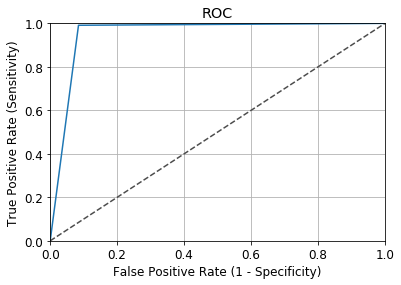

AUC: 0.953355276559926


In [136]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, y_pred)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)
plt.show()

print('AUC:', auc(fpr, tpr))

#### LDA  +  Randaom Forest

https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html

In [78]:
# 1.根据LDA，用30个主题来表示文档
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
cntVector = CountVectorizer()
cntTf = cntVector.fit_transform(content)

lda = LatentDirichletAllocation(n_components = 30,
                                learning_offset = 20.,
                                random_state = 0)
docres = lda.fit_transform(cntTf)

In [88]:
docres.shape

(74855, 30)

In [120]:
# 训练结果显示第四篇文章与第26个主题相关度很高，但实际上并没有
docres[3]

array([0.00208333, 0.00208333, 0.00208333, 0.00208333, 0.00208333,
       0.00208333, 0.00208333, 0.00208333, 0.00208333, 0.00208333,
       0.00208333, 0.00208333, 0.00208333, 0.00208333, 0.00208333,
       0.00208333, 0.00208333, 0.00208333, 0.31788375, 0.00208333,
       0.00208333, 0.00208333, 0.00208333, 0.00208333, 0.00208333,
       0.00208333, 0.62378292, 0.00208333, 0.00208333, 0.00208333])

In [91]:
n_top_words = 20
vocab = cntVector.get_feature_names()
for i, topic_dist in enumerate(lda.components_):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words + 1):-1]
    print('Topic {}: {}'.format(i, ' '.join(topic_words)))

Topic 0: 研究 城市 房地产 发现 价格 垃圾 住房 北京 人员 显示 影响 数据 记者 出现 增加 调控 可能 市场 患者 nnn
Topic 1: 我们 一个 自己 他们 没有 这个 孩子 可以 就是 这样 现在 已经 很多 因为 还是 生活 希望 开始 一些 需要
Topic 2: 美国 总统 报道 表示 韩国 叙利亚 问题 法国 政府 选举 新华社 俄罗斯 国家 媒体 事件 组织 特朗普 记者 朝鲜 举行
Topic 3: 香港 公司 信息 通过 网络 平台 共享 记者 单车 相关 进行 服务 支付 表示 犯罪 万元 可以 提供 用户 使用
Topic 4: 新华社 2017 选手 照片 体育 比赛 当日 中国 记者 举行 乒乓球 锦标赛 决赛 晋级 战胜 n4 羽毛球 世界 n5 江苏
Topic 5: 台湾 大陆 两岸 一个 中国 表示 人工智能 民进党 收报 台北 英文 港元 两岸关系 当局 我们 巴拿马 图片 内容 可以 方面
Topic 6: 学生 体育 中国 学校 教育 参加 运动 北京 记者 赛事 专业 大学 比赛 进行 学院 活动 项目 校园 来自 孩子
Topic 7: 合作 中国 一带 一路 发展 国际 主席 新华社 国家 双方 倡议 共同 习近平 世界 记者 高峰论坛 关系 表示 北京 中方
Topic 8: 中国 nnn 记者 无人机 新华社 铁路 肯尼亚 编辑 工作 蒙内 列车 视频 nnnnnn 内罗毕 一个 他们 地铁 北京 医生 项目
Topic 9: 中国 新华社 海军 北京 记者 武术 维和 减持 国际 苏丹 编队 斯里兰卡 2017 太极拳 照片 国家 训练 进行 官兵 当地
Topic 10: 乘客 班列 机场 中欧 希腊 集装箱 中远 新华社 码头 航班 msci 飞机 海运 港口 萨德 捐献 以色列 记者 韩国 航空公司
Topic 11: 新华社 2017 比赛 球员 足球 照片 当日 赛季 联赛 体育 主场 20162017 n4 战胜 n5 记者 路透 北京 球队 客场
Topic 12: 外代 二线 足球 联赛 新华社 晋级 2017 nn1 nn2 nn3 nn4 欧新 nn5 网球 欧冠 照片 时装周 nn6 法新 英超
Topic 13: 中国 一带 一路 国家 国际 合作 经济 建设 项目 

In [96]:
# 2.训练集验证
X1_train, X1_test, y1_train, y1_test = train_test_split(docres, y, test_size=0.3, random_state=42)
rf_model1 = RandomForestClassifier(n_estimators=200, random_state=1080)
rf_model1.fit(X1_train, y1_train)
print("val mean accuracy: {0}".format(rf_model1.score(X1_test, y1_test)))
y1_pred = rf_model1.predict(X1_test)
print(classification_report(y1_test, y1_pred))
rf_matrix1 = confusion_matrix(y1_test, y1_pred)        
print(rf_matrix1)

val mean accuracy: 0.9209155274524647
              precision    recall  f1-score   support

           0       0.77      0.37      0.50      2390
           1       0.93      0.99      0.96     20067

    accuracy                           0.92     22457
   macro avg       0.85      0.68      0.73     22457
weighted avg       0.91      0.92      0.91     22457

[[  880  1510]
 [  266 19801]]


不足：

抽取出的主题不清晰，可能影响了最终的分类效果。

在用TF-IDF和LDA提取特征时，都是用所有文本（训练集、验证集），导致生成的模型同时受到了训练集和验证集数据的影响。

### Congratulations! You have completed all assignments in this week. The question below is optional. If you still have time, why don't try it out.

## Option:

#### Try differnt machine learning algorithms with different combinations of parameters in the practical part, and compare their performances (Better use some visualization techiniques).

继续用逻辑回归、决策树、支持向量机、朴素贝叶斯和XGboost，XGboost和决策树的分类准确度都较高，决策树的训练速度更快。

In [137]:
pd.options.mode.chained_assignment = None

# 1.逻辑回归
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)
print("val mean accuracy: {0}".format(lr_model.score(X_test, y_test)))
y_pred = lr_model.predict(X_test)
# print(classification_report(y_test, y_pred))

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


val mean accuracy: 0.9708776773389144


In [138]:
# 交叉验证找最佳参数
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
num_folds = 10
seed = 7
scoring = 'accuracy'

param_grid = {}
param_grid['C'] = [0.1,5,13,15]
model = LogisticRegression()
kfold = KFold(n_splits=num_folds,random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, y_train)
print('最优 : %s 使用 %s' % (grid_result.best_score_, grid_result.best_params_))

最优 : 0.9736249475170808 使用 {'C': 15}


In [139]:
# 2.决策树
from sklearn.tree import DecisionTreeClassifier
tree_model = DecisionTreeClassifier(max_features = 30)
tree_model.fit(X_train, y_train)
print("val mean accuracy: {0}".format(tree_model.score(X_test, y_test)))
y_pred = tree_model.predict(X_test)
# print(classification_report(y_test, y_pred))

val mean accuracy: 0.9763548114173755


In [131]:
# 3.SVM
from sklearn.svm import SVC
svm_model = SVC()
svm_model.fit(X_train, y_train)
print("val mean accuracy: {0}".format(svm_model.score(X_test, y_test)))
y_pred = svm_model.predict(X_test)
# print(classification_report(y_test, y_pred))

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


val mean accuracy: 0.9624615932671328


In [127]:
# 4.LinearSVC
from sklearn.svm import LinearSVC
lsvm_model = LinearSVC()
lsvm_model.fit(X_train, y_train)
print("val mean accuracy: {0}".format(lsvm_model.score(X_test, y_test)))
y_pred = lsvm_model.predict(X_test)
# print(classification_report(y_test, y_pred))

val mean accuracy: 0.9653114841697467


虽然准确度相差不大，但LinearSVC的训练速度明显比SVC要快

In [128]:
# 5.贝叶斯
from sklearn.naive_bayes import MultinomialNB
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
print("val mean accuracy: {0}".format(nb_model.score(X_test, y_test)))
y_pred = nb_model.predict(X_test)
# print(classification_report(y_test, y_pred))

val mean accuracy: 0.9046177138531416


In [11]:
# 6.XGboost
xg_model = XGBClassifier()
xg_model.fit(X_train, y_train)
print("val mean accuracy: {0}".format(xg_model.score(X_test, y_test)))
y_pred = xg_model.predict(X_test)
# print(classification_report(y_test, y_pred))

val mean accuracy: 0.9820545932226032


Text(0.5, 1.0, 'DecisionTreeClassifier Decision Region Boundary')

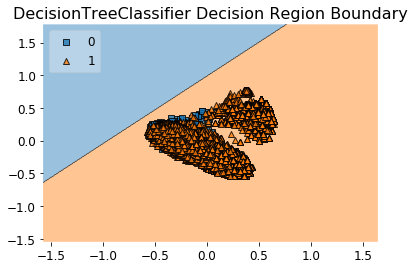

In [168]:
from sklearn.decomposition import PCA
from mlxtend.plotting import plot_decision_regions

clf =  LinearSVC()
pca = PCA(n_components = 2)
X_train2 = pca.fit_transform(X.toarray())
clf.fit(X_train2, y.values)
plot_decision_regions(X_train2,  y.values, clf=clf, legend=2)

plt.title('DecisionTreeClassifier Decision Region Boundary', size=16)